# ART.T551 Image and Video Recognition Final Report

## 20M31378 Xu Hongkun



## Siamese Network

In [ ]:
import torch
from torch import optim
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
import random

from invert import Invert

In [ ]:
# star, note, heart, diamond, cross 
Dataset = ["U26E4", "U266B", "U2661", "U2662", "U2715"]

Training_Path = "./TrainDataset"
Testing_Path = "./TestDataset"

BATCH_SIZE = 10
IMG_SIZE= 256

## 1. Dataset

In [ ]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
    """
    自定义Dataset类，__getitem__(self, index)每次返回(img1, img2, 0/1)
    """
  
    def __init__(self,imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert  
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #5个类别中任选一个
        
        # Make sure the first element is an element that has already been learned
        while img0_tuple[1] > 4:
            img0_tuple = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0,1) #保证同类样本约占一半
        if should_get_same_class:
            while True:
                #直到找到不是自己的同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1] and img0_tuple[0]!=img1_tuple[0]:
                    break
        else:
            while True:
                #直到找到非同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # 转换成灰度图像
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]==img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
from torchvision.datasets import ImageFolder

# 1. 孪生网络训练集(training dataset)
training_dataset = ImageFolder(Training_Path)
train_class = training_dataset.class_to_idx
print("train dataset labels:", train_class) # 检查训练数据集对应文件夹的label

siamese_train_dataset = SiameseNetworkDataset(imageFolderDataset=training_dataset, transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor()]), should_invert=True)

train_loader = torch.utils.data.DataLoader(siamese_train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           )

# 2. 孪生网络测试集(testing dataset)
testing_dataset = ImageFolder(Testing_Path)
test_class = testing_dataset.class_to_idx
print("test dataset labels:", test_class) # 检查测试数据集对应文件夹的label
siamese_test_dataset = SiameseNetworkDataset(imageFolderDataset=testing_dataset, transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor()]), should_invert=True)

test_loader = torch.utils.data.DataLoader(siamese_test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           )

# 3. 原始训练集(common dataset)
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.Grayscale(num_output_channels=1), # 灰度化
                                Invert(),
                                # transforms.RandomHorizontalFlip(), # 随机水平翻转
                                transforms.ToTensor(),
                                ])

dataset = ImageFolder(Training_Path, transform=transform)
common_train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size = 50,
                                           shuffle=False,
                                           )


train dataset labels: {'U2661': 0, 'U2662': 1, 'U266B': 2, 'U26E4': 3, 'U2715': 4}
test dataset labels: {'U2661': 0, 'U2662': 1, 'U266B': 2, 'U26E4': 3, 'U2715': 4, 'UF07E': 5, 'UF082': 6}


### Training Samples

labels: [0. 0. 1. 1. 0. 1. 0. 0. 1. 0.]


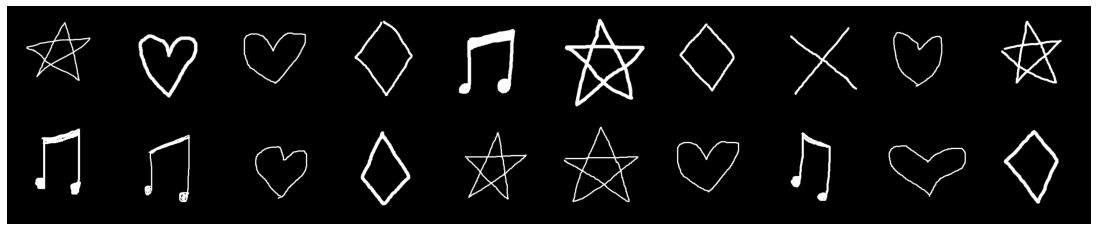

In [ ]:
batch = next(iter(train_loader))
image1, image2, labels = batch
concatenated = torch.cat((image1,image2), 0)
images = torchvision.utils.make_grid(concatenated, nrow=BATCH_SIZE)

plt.figure(figsize=(40,4))
plt.imshow(np.transpose(images, (1,2,0)))
plt.axis('off')
esp_fig = plt.gcf() # get current figure
esp_fig.savefig('./images/Siamese_Training_Data.png', format='png', bbox_inches='tight')

print('labels:', labels.numpy().reshape(BATCH_SIZE))
plt.show()

torch.Size([50, 1, 256, 256]) 	 torch.Size([50])


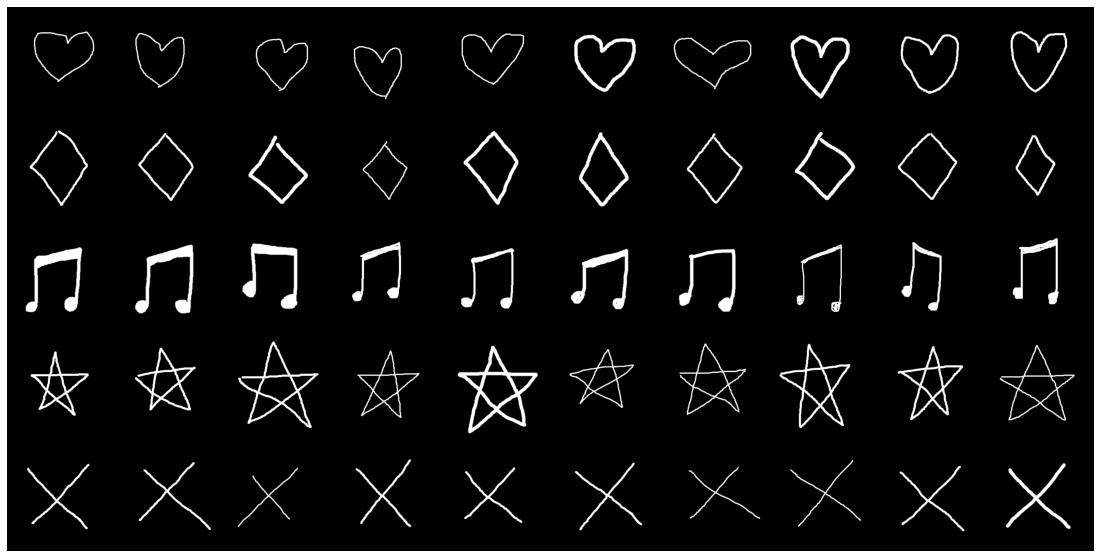

[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]]


In [ ]:
# check common dataloader
batch = next(iter(common_train_loader))
images, labels = batch
print(images.shape,'\t',labels.shape)
images = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(np.transpose(images, (1,2,0)))
esp_fig = plt.gcf() # get current figure
esp_fig.savefig('./images/All_Training_Data.png', format='png', bbox_inches='tight')
plt.show()
print(labels.numpy().reshape(-1,10))

### Testing Samples

labels: [0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]


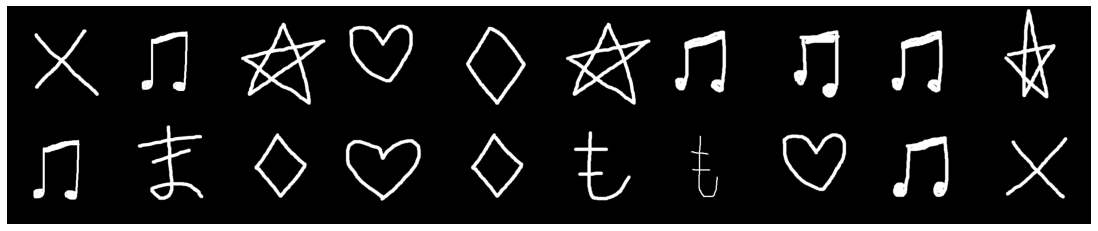

In [ ]:
batch = next(iter(test_loader))
image1, image2, labels = batch
concatenated = torch.cat((image1,image2), 0)
images = torchvision.utils.make_grid(concatenated, nrow=BATCH_SIZE)

plt.figure(figsize=(40,4))
plt.imshow(np.transpose(images, (1,2,0)))
plt.axis('off')
esp_fig = plt.gcf() # get current figure
esp_fig.savefig('./images/Siamese_Testing_Data.png', format='png', bbox_inches='tight')

print('labels:', labels.numpy().reshape(BATCH_SIZE))
plt.show()

## 2. Model

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            # 1, 256, 256
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2),
            
            # 4, 128, 128
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            
            # 8, 64, 64
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2)
            
            # 8, 32, 32
        )

        self.fc1 = nn.Sequential(
            # 8, 32, 32
            nn.Linear(8*32*32, 1000),
            nn.ReLU(inplace=True),
            
            # 1000
            nn.Linear(1000, 100),
            nn.ReLU(inplace=True),
            
            # 100
            nn.Linear(100, 3)
            
            # 3
        )
        
        
    def onceforward(self, inputvec):
        outputvec = self.cnn1(inputvec)
        outputvec = outputvec.view(outputvec.size()[0], -1)
        outputvec = self.fc1(outputvec)

        return outputvec
    
        
    def forward(self, input1, input2):
        output1 = self.onceforward(input1)
        output2 = self.onceforward(input2)
        return output1, output2
        
        # output = torch.cat((output1, output2),1)
        # output = self.fc1(output)
        # return output
        

## 3. Training

### loss function

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim = True)
        # MAX(margin - euclidean_distance, 0)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + 
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) 

        return loss_contrastive

### training

In [ ]:
# Hyperparameters
NUMBER_EPOCHS= 100
# 是不是一样的阈值
THRESHOLD = 1

net = SiameseNetwork()
# criterion = nn.CrossEntropyLoss() # Cross-Entropy loss
criterion = ContrastiveLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
Training_loss_history = [] 
Testing_loss_history = []
iteration_number = 0
Correct_number = 0

for epoch in range(0, NUMBER_EPOCHS):
    # print("Epoch：", epoch, " start.")
    for i, batch in enumerate(train_loader, 0):
        img0, img1, labels = batch #img:tensor[batch_size,channels,width,length], label:tensor[batch_size,label]
        # img0, img1, labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        
        optimizer.zero_grad() # clear the calculated grad in previous batch
        output1, output2 = net(img0, img1)
        training_loss = criterion(output1, output2, labels)
        training_loss.backward()
        optimizer.step()
        
        if i % 10 == 0 :# show changes of loss value after each 10 batches

            with torch.no_grad():
                Correct_number = 0
                for items in test_loader:
                    test_img0, test_img2, test_labels = items
                    test_output1, test_output2 = net(test_img0, test_img2)
                    
                    test_euclidean_distance = torch.nn.functional.pairwise_distance(test_output1, test_output2)
                    Prediction_labels = np.where(test_euclidean_distance < THRESHOLD, 1, 0)
                    # print(Prediction_labels)
                    # print(test_labels.flatten().numpy().astype(np.int32))
                    Correct_number += np.logical_not(np.logical_xor(Prediction_labels,test_labels.flatten().numpy().astype(np.int32))).sum()
                
                test_accuracy = 100 * Correct_number/(len(test_loader)*BATCH_SIZE)

            print(f"Epoch: {epoch}, Training loss: {training_loss.item()}, Test accuracy: {test_accuracy:.2f}%")

            iteration_number += 10
            counter.append(iteration_number)
            Training_loss_history.append(training_loss.item())
            Testing_loss_history.append(test_accuracy)   
                    

# save model
torch.save(net, './model/Model1.pkl')


Epoch: 0, Training loss: 1.696885108947754, Test accuracy: 37.50%
Epoch: 1, Training loss: 1.073224663734436, Test accuracy: 52.50%
Epoch: 2, Training loss: 0.3612964153289795, Test accuracy: 75.00%
Epoch: 3, Training loss: 0.4991775453090668, Test accuracy: 72.50%
Epoch: 4, Training loss: 0.8329024314880371, Test accuracy: 67.50%
Epoch: 5, Training loss: 0.515849232673645, Test accuracy: 67.50%
Epoch: 6, Training loss: 0.24930742383003235, Test accuracy: 62.50%
Epoch: 7, Training loss: 0.16092561185359955, Test accuracy: 75.00%
Epoch: 8, Training loss: 0.15786074101924896, Test accuracy: 77.50%
Epoch: 9, Training loss: 0.07665596902370453, Test accuracy: 75.00%
Epoch: 10, Training loss: 0.08890529721975327, Test accuracy: 80.00%
Epoch: 11, Training loss: 0.07402290403842926, Test accuracy: 80.00%
Epoch: 12, Training loss: 0.08641604334115982, Test accuracy: 70.00%
Epoch: 13, Training loss: 0.12862709164619446, Test accuracy: 75.00%
Epoch: 14, Training loss: 0.06599151343107224, Test a

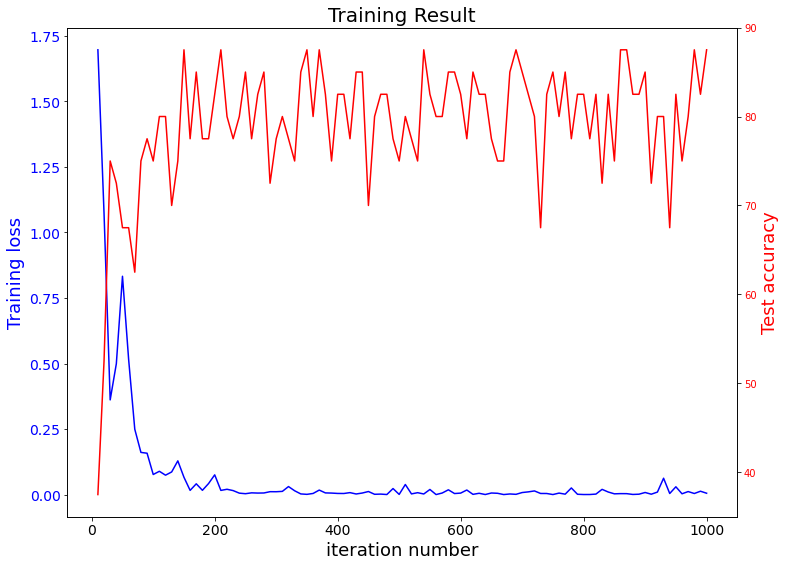

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,9))
plt.title("Training Result", fontsize=20)
plt.xlabel('iteration number', fontsize=18)

# plt.grid(axis='y',color='grey',linestyle='--',lw=0.5,alpha=0.5)
plt.tick_params(axis='both',labelsize=14)
plot1 = ax1.plot(counter, Training_loss_history, 'b', label='Training loss')
ax1.set_ylabel('Training loss', fontsize = 18)
ax1.yaxis.label.set_color('blue')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
plot2 = ax2.plot(counter, Testing_loss_history, 'r', label='Test accuracy')
# ax2.set_ylim(0,1.1)
ax2.yaxis.label.set_color('red')
ax2.set_ylabel('Test accuracy',fontsize=18)
for tl in ax2.get_yticklabels():
    tl.set_color('r')

# ax1.set_yticks(np.linspace(ax1.get_ybound()[0],ax1.get_ybound()[1],9)) 
# ax2.set_yticks(np.linspace(ax2.get_ybound()[0],ax2.get_ybound()[1],9)) 

esp_fig = plt.gcf() # get current figure
esp_fig.savefig('./images/Training_Result.png', format='png', bbox_inches='tight')

plt.show()

## 4. Check Result

In [ ]:
# Check_dataloader = torch.utils.data.DataLoader(siamese_train_dataset, shuffle=True, batch_size=1)
Check_dataloader = torch.utils.data.DataLoader(siamese_test_dataset, shuffle=True, batch_size=1)

In [ ]:
def imshow(img, text=None, should_save=False): 
    #展示一幅tensor图像，输入是(C,H,W)
    npimg = img.numpy() #将tensor转为ndarray
    plt.axis("off")
    if text:
        plt.text(340, 240, text, style='italic',fontweight='bold', color = "white") # bbox={'facecolor':'white', 'alpha':0.6, 'pad':10}
    return np.transpose(npimg, (1, 2, 0)) #转换为(H,W,C)
  

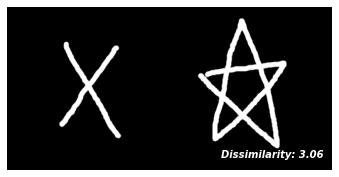

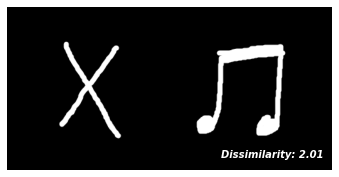

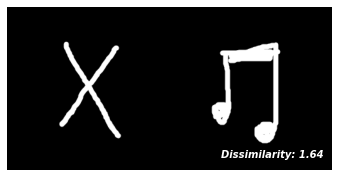

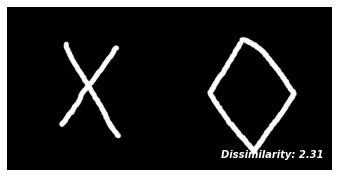

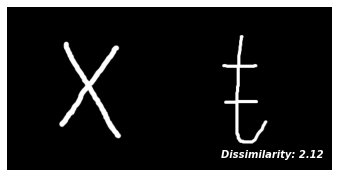

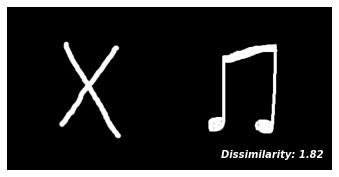

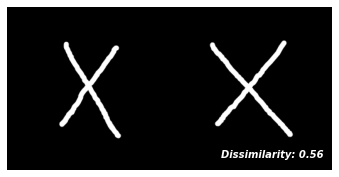

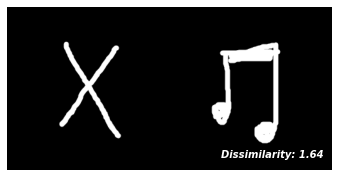

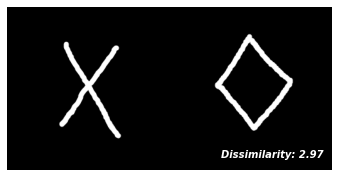

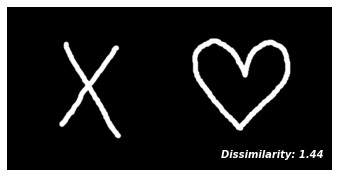

In [ ]:
# Load Model
model1 = torch.load('./model/Model1.pkl')

#生成对比图像
dataiter = iter(Check_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0, x1),0)
    # output1,output2 = net(x0, x1)
    output1,output2 = model1(x0, x1)
    euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
    images = torchvision.utils.make_grid(concatenated)

    plt.figure(figsize=(6,3))
    plt.imshow(imshow(images, f'Dissimilarity: {euclidean_distance.item():.2f}'))
    plt.savefig('./images/Result%s.png'%i, format='png', bbox_inches='tight')
    plt.plot()

### 3D display

In [ ]:
print(train_class)
print(u"\u2661", u"\u2662", u"\u266B", u"\u26E4", u"\u2715")

{'U2661': 0, 'U2662': 1, 'U266B': 2, 'U26E4': 3, 'U2715': 4}
♡ ♢ ♫ ⛤ ✕


In [ ]:
Container = {'0':[], '1':[], '2':[], '3':[], '4':[]}

for items in common_train_loader:
    images, labels = items
    output1, output2 = net(images, images)
    for i, val in enumerate(labels, 0):
        Container[str(val.item())].append(output1[i])

In [ ]:
Container

{'0': [tensor([-0.9458,  0.1652, -0.2740], grad_fn=<SelectBackward>),
  tensor([-0.9677,  0.1679, -0.2867], grad_fn=<SelectBackward>),
  tensor([-0.9452,  0.1877, -0.2560], grad_fn=<SelectBackward>),
  tensor([-0.9642,  0.1515, -0.2761], grad_fn=<SelectBackward>),
  tensor([-0.9734,  0.1691, -0.2843], grad_fn=<SelectBackward>),
  tensor([-0.9518,  0.1755, -0.2641], grad_fn=<SelectBackward>),
  tensor([-0.9695,  0.1586, -0.2921], grad_fn=<SelectBackward>),
  tensor([-0.9851,  0.1636, -0.2911], grad_fn=<SelectBackward>),
  tensor([-0.9560,  0.1707, -0.2827], grad_fn=<SelectBackward>),
  tensor([-0.9837,  0.1586, -0.3041], grad_fn=<SelectBackward>)],
 '1': [tensor([-0.5069, -1.7707, -1.1048], grad_fn=<SelectBackward>),
  tensor([-0.5124, -1.7487, -1.1047], grad_fn=<SelectBackward>),
  tensor([-0.4777, -1.6921, -1.0181], grad_fn=<SelectBackward>),
  tensor([-0.5349, -1.7687, -1.1282], grad_fn=<SelectBackward>),
  tensor([-0.5109, -1.7391, -1.0862], grad_fn=<SelectBackward>),
  tensor([-0.5

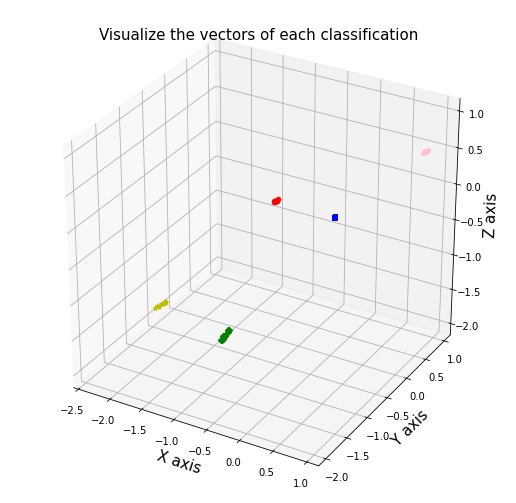

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
ax.set_xlim(-2.5, 1.1)
ax.set_ylim(-2.1, 1.1)
ax.set_zlim(-2.1, 1.1)

for item in Container['0']:
    x, y, z = item.detach().numpy()
    ax.scatter(x, y, z, c='r', marker='o')
    # ax.text(x, y, z, u"\u2661", fontsize=9, bbox={'facecolor':'white'})

for item in Container['1']:
    x, y, z = item.detach().numpy()
    ax.scatter(x, y, z, c='g', marker='D')

for item in Container['2']:
    x, y, z = item.detach().numpy()
    ax.scatter(x, y, z, c='b', marker='s')

for item in Container['3']:
    x, y, z = item.detach().numpy()
    ax.scatter(x, y, z, c='y', marker='*')

for item in Container['4']:
    x, y, z = item.detach().numpy()
    ax.scatter(x, y, z, c='pink', marker='p')
    
ax.set_xlabel('X axis', fontsize=15)
ax.set_ylabel('Y axis', fontsize=15)
ax.set_zlabel('Z axis', fontsize=15)
plt.title('Visualize the vectors of each classification', fontsize=15)     # 图表名称
plt.savefig('./images/3D_Result.png', format='png', bbox_inches='tight')
plt.show()

## 5. Save Data

In [ ]:
# Save the average vector of each class
Result_Data = dict()

with torch.no_grad():
    for i, name in enumerate(list(train_class.keys()), 0):
        Result_Data[name] = torch.mean(torch.stack(Container[str(i)]), dim=0)

# print(Result_Data)

torch.save(Result_Data, './model/Mean_Tensor.pt')

### check file

In [ ]:
t = torch.load('./model/Mean_Tensor.pt')
t

{'U2661': tensor([-0.9643,  0.1669, -0.2811]),
 'U2662': tensor([-0.5024, -1.7368, -1.0777]),
 'U266B': tensor([ 0.5966, -0.9183,  0.4116]),
 'U26E4': tensor([-2.3164, -0.5438, -1.7574]),
 'U2715': tensor([0.6301, 1.2904, 0.2664])}

In [ ]:
# Minimum distance between tensors
torch.nn.functional.pairwise_distance(torch.Tensor([[-0.5024, -1.7368, -1.0777]]), torch.Tensor([[-2.3164, -0.5438, -1.7574]])).item()

2.2750473022460938